In [23]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
my_example_nc_file = 'EUREC4A_HALO_BAHAMAS-Radiometer_20200128a.nc'
fh = Dataset(my_example_nc_file, mode='r')
df_fdir = pd.read_csv('BBR_DirectFraction_Flight_20200128a_R0.dat',skiprows = 34,delim_whitespace=True)
df_fdw = pd.read_csv('BBR_Fdn_clear_sky_Flight_20200128a_R0.dat',skiprows = 34, delim_whitespace=True)
#nav = pd.read_csv('Nav_IMS0000_02022020.Asc',skiprows=14, header=None,delim_whitespace=True)
fdw_time = df_fdw.loc[:,['sod','F_dw']]
fdir_time = df_fdir.loc[:,'f_dir']
db = pd.concat([fdw_time,fdir_time],axis=1)
db.set_index('sod',inplace=True)
time = fh.variables['TIME'][:] # time
time_bac = pd.DataFrame(time.T, columns = ['time'])
time_bac = time_bac/1000
time_bac

#print(fh.variables.keys())

,time
0,53914.0
1,53914.1
2,53914.2
3,53914.3
4,53914.4
...,...
322035,86117.5
322036,86117.6
322037,86117.7
322038,86117.8


In [24]:
fdw_time

,sod,F_dw
0,52009,777.509522
1,52129,781.799988
2,52249,785.827393
3,52369,790.070251
4,52489,794.049194
...,...,...
206,76755,143.628021
207,76875,133.450363
208,76995,122.412567
209,77115,110.577972


In [25]:
array = np.arange(52009,86117, 1) #41249 77030  333190 rows × 1 columns
arr = array.repeat(10)
df_arr = pd.DataFrame(arr, columns = ['time_arr'])
df_arr.set_index('time_arr',inplace=True)
data = df_arr.join(db)
data_int= data.interpolate(method='linear', limit_direction='forward', axis=0)
# data_int.drop(data_int.index[0:12089],inplace=True)
data_int.reset_index(inplace=True)
data_int.columns=['time','F_dw','f_dir']  #start:22810,end:355999
#data_int
#data_int[data_int.time==86116]
df = data_int.iloc[19040:341080,:]
df.reset_index(inplace=True,drop=True)
df.drop(['time'],axis=1)

,F_dw,f_dir
0,842.998179,0.864189
1,843.008598,0.864195
2,843.019016,0.864202
3,843.029434,0.864209
4,843.039852,0.864216
...,...,...
322035,98.015861,0.862011
322036,98.015861,0.862011
322037,98.015861,0.862011
322038,98.015861,0.862011


In [44]:
ri = fh.variables['IRS_PHI'][:] # roll angle "deg"
#ro = pd.DataFrame(ri.T)
pi = fh.variables['IRS_THE'][:] # pitch angle "deg"
#po = pd.DataFrame(pi.T)
yi = fh.variables['IRS_HDG'][:] # yaw angle "deg"
#y = pd.DataFrame(yi.T)
szai = fh.variables['SUN_ALT'][:] # solar altitude angle
#sza = pd.DataFrame(szai.T)
saai = fh.variables['SUN_AZI'][:] # solar azimuth angle
#saa = pd.DataFrame(saai.T)
fdw = df.loc[:,'F_dw']
fdir = df.loc[:,'f_dir']
SWd = fh.variables['FDSC'][:]
SWD = pd.DataFrame(SWd.T)
SWD.columns=['swu']
r_off = 0
p_off = 0


import math

def Fdw_attitude_correction(fdw,r,p,yi,szai,saai,r_off,p_off,fdir):

    r = ri+r_off
    p = pi+p_off
    for i in szai:
        for j in saai:
            for k in r:
                for l in p:
                    for m in yi:
                        for n in fdw:
                            for o in fdir:
                                eq1 = math.sin((90-i)*(math.pi/180))
                                eq2 = math.cos((90-i)*(math.pi/180))*math.sin(k*(math.pi/180))*math.sin((j-m)*(math.pi/180))
                                eq3 = math.cos((90-i)*(math.pi/180))*math.sin(l*(math.pi/180))
                                eq4 = math.cos(k*(math.pi/180))*math.cos((j-m)*(math.pi/180))
                                eq5 = math.sin((90-i)*(math.pi/180))*math.cos(l*(math.pi/180))*math.cos(k*(math.pi/180))
                                #factor = eq1/((eq2-eq3*(eq4+eq5))
                                factor = eq1/(eq2+eq3+eq4+eq5)
                                Fdw=o*n*factor+(1-o)*n
                                print(eq1)
                                return Fdw
correction_weighted = Fdw_attitude_correction(fdw,ri,pi,yi,szai,saai,r_off,p_off,fdir)

# corrected_FDSC = SWD.swu + correction_weighted
# swd_correct = pd.DataFrame(corrected_FDSC)
# swd_correct.columns = ['swd_corr']
# swd_correct


0.5892978964828729


In [15]:
SWu = fh.variables['FUS'][:]
LWu = fh.variables['FDL'][:]
LWd = fh.variables['FUL'][:]
SWU = pd.DataFrame(SWu.T)
LWU = pd.DataFrame(LWu.T)
LWD = pd.DataFrame(LWd.T)
df_big = pd.concat([time_bac,SWD,swd_correct,SWU,LWU,LWD],axis =1)
df_big.columns = ['Time', 'ShortWave_down','ShortWave_down_corr', 'ShortWave_up','LongWave_down', 'LongWave_up']
df_big['Time'] = df_big.loc[:,'Time'].round(1)
df_big

,Time,ShortWave_down,ShortWave_down_corr,ShortWave_up,LongWave_down,LongWave_up
0,53914.0,891.265259,1456.795944,36.021637,387.893951,573.260376
1,53914.1,890.692078,1456.222763,36.377426,386.465027,573.032471
2,53914.2,888.923828,1454.454514,36.318420,387.815582,573.299255
3,53914.3,888.524109,1454.054794,36.480495,385.538177,572.458862
4,53914.4,887.538086,1453.068771,36.038483,384.677155,571.878296
...,...,...,...,...,...,...
322035,86117.5,-0.906200,564.624486,-2.878024,392.024475,481.956329
322036,86117.6,-1.113852,564.416834,-2.991964,388.792023,482.389313
322037,86117.7,-0.911150,564.619536,-2.961419,384.575714,482.662201
322038,86117.8,-2.392870,563.137815,-3.263771,383.841766,483.014191


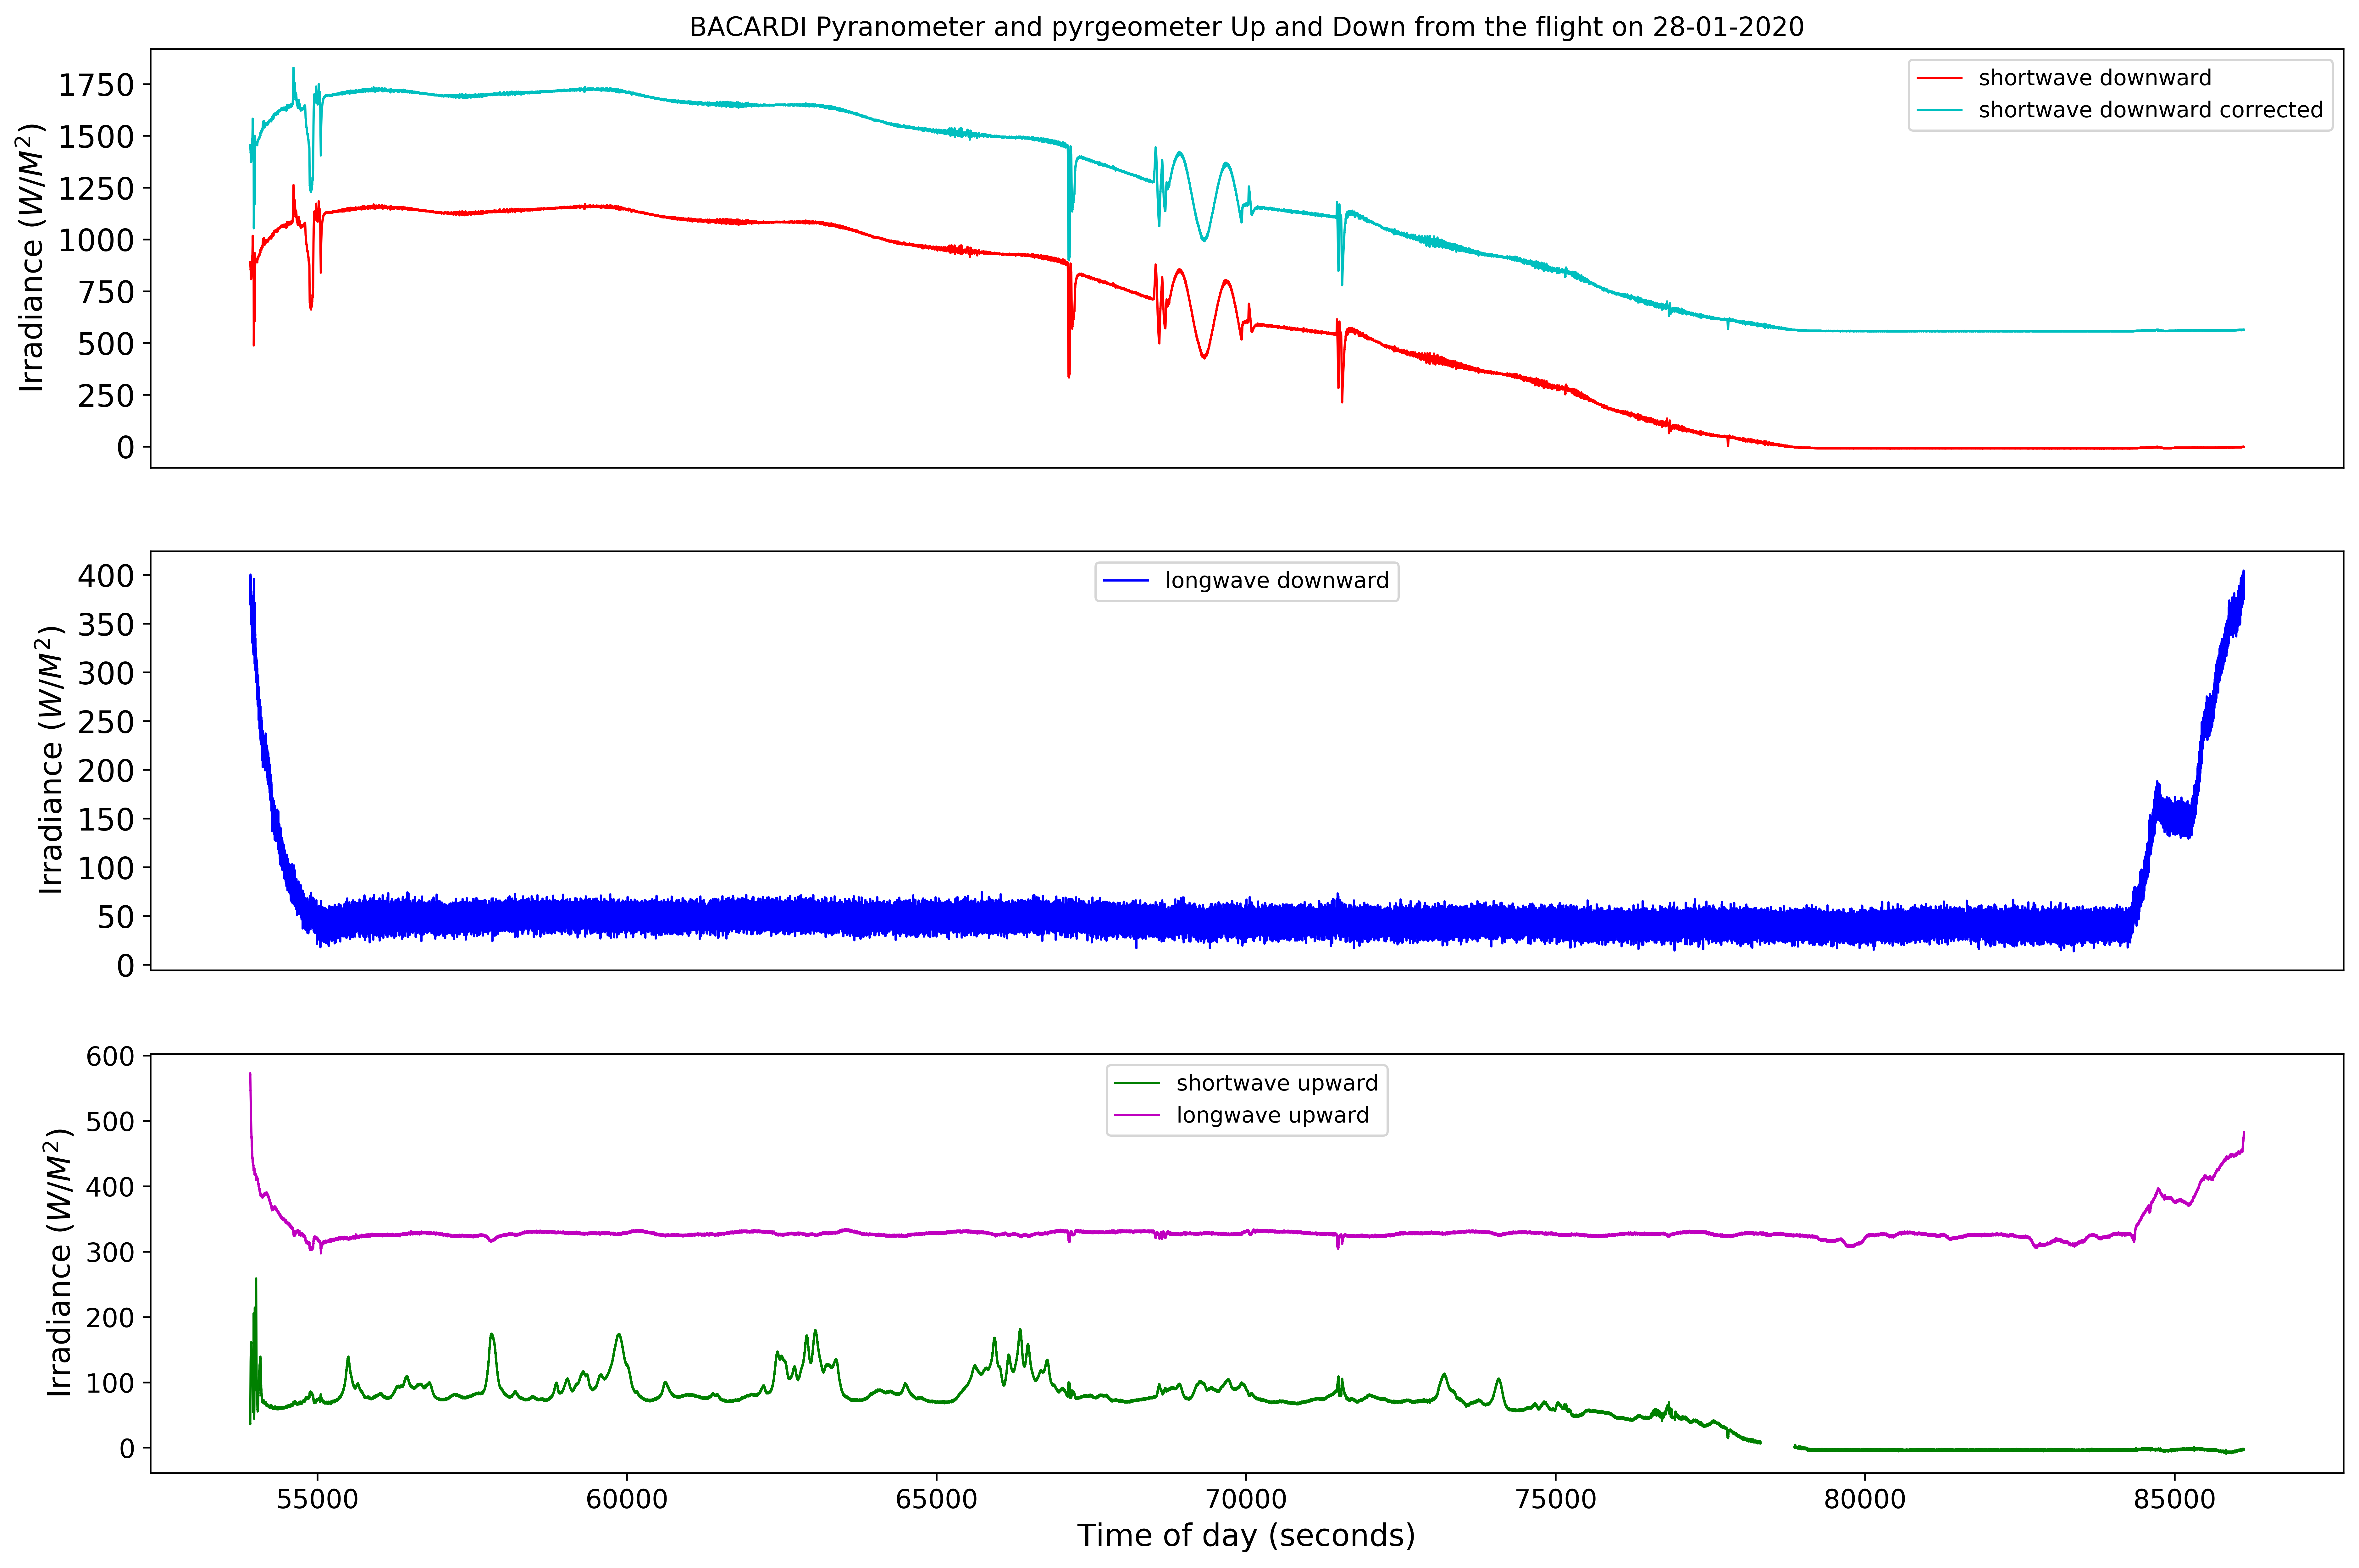

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
#df_new_24jan = pd.read_csv('df_new_24jan.csv')
plt.figure(figsize=(18,12),dpi=500)
plt.subplot(311)
plt.plot(df_big.Time,df_big.ShortWave_down, 'r', label = 'shortwave downward',linewidth=1)
plt.plot(df_big.Time,df_big.ShortWave_down_corr, 'c', label = 'shortwave downward corrected',linewidth=1)
plt.title('BACARDI Pyranometer and pyrgeometer Up and Down from the flight on 28-01-2020')
plt.ylabel('Irradiance ($W/M^2$)',fontsize=14)
plt.xticks([], [])
plt.yticks(fontsize=14)
plt.legend(fontsize=10)
plt.subplot(312)
plt.plot(df_big.Time,df_big.LongWave_down, 'b', label = 'longwave downward',linewidth=1)
plt.ylabel('Irradiance ($W/M^2$)',fontsize=14)
plt.xticks([], [])
plt.yticks(fontsize=14)
plt.legend(fontsize=10)
plt.subplot(313)
plt.plot(df_big.Time,df_big.ShortWave_up, 'g', label = 'shortwave upward',linewidth=1)
plt.plot(df_big.Time,df_big.LongWave_up, 'm', label = 'longwave upward',linewidth=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Irradiance ($W/M^2$)',fontsize=14)
plt.xlabel('Time of day (seconds)',fontsize=14)
plt.legend(fontsize=10)
plt.show()